In [1]:
import os
import json
import time
import datetime as dt
import numpy as np
import pandas as pd
import factoroid as fr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

WebSQL = fr.connector.MySQLDB('db-01')
DevSQL = fr.connector.MySQLDB('db-dev')

Successfully connected; Factorid web services
Successfully connected; Factoroid development


In [2]:
from model.utils_function import *
from model.utils_cycle import *
from model.utils_output import *
from model.utils_main import *

In [29]:
now = dt.datetime(2022, 4, 21, 8)
# now = dt.datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)
# now = now - dt.timedelta(days=2) if now.weekday() == 0 else now
print(now)

2022-04-21 08:00:00


In [30]:
str_datetime = str(now.date())
if not os.path.exists(f'./result/{str_datetime}'):
    os.mkdir(f'./result/{str_datetime}')

In [31]:
# SO data load
# SO data merge

so = pd.DataFrame(WebSQL.query(f'''
                                    SELECT stop.equipment_name AS equipment_name, stop.order_number AS so, stop.gop AS gop, stop.material AS material, stop.qty AS qty, start.report_date AS start_time, MAX(stop.report_date) AS stop_time
                                    FROM so_log_yulkok AS stop
                                    LEFT JOIN (SELECT equipment_name, order_number, gop, material, qty, MIN(report_date) AS report_date
                                            FROM so_log_yulkok
                                            WHERE equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                     'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                     'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                            AND status = '보고시작' AND report_date >= '{str(now - dt.timedelta(days=7))}' AND report_date <= '{str(now)}'
                                            GROUP BY equipment_name, order_number, gop, material, qty) AS start
                                            ON stop.equipment_name = start.equipment_name AND stop.order_number = start.order_number AND stop.gop = start.gop AND stop.material = start.material AND stop.qty = start.qty
                                    WHERE stop.equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                  'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                  'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                    AND stop.status = '보고완료' AND stop.completion_flag = 'X' AND stop.report_date >= '{str(now - dt.timedelta(days=1))}' AND stop.report_date < '{str(now)}'
                                    GROUP BY equipment_name, so, gop, material, qty;
                                '''), columns=['equipment_name', 'so', 'gop', 'material', 'qty', 'start_time', 'stop_time', 'total_runtime'])

so.total_runtime = round((so.stop_time - so.start_time) / np.timedelta64(1,'h'), 3)
so = so.dropna().sort_values(by=['equipment_name', 'start_time']).reset_index(drop=True)

In [32]:
cycle_summary = pd.DataFrame(columns=['factory_id', 'process_id', 'equipment_id', 'equipment_name', 
                                      'material', 'so', 'gop', 'qty', 'cycle_number', 'start_time', 'stop_time',
                                      'spindle', 'idle_inter', 'total'])

In [33]:
so_g = so.groupby(['equipment_name'])
so_g_keys = list(so_g.groups.keys())
if not so_g_keys:
    print('Not found SO data')
else:
    print(f'machine\nSO data length: {so.shape[0]}\n')
    # print(f'machine\nSO data length: {so.shape[0]}\n{", ".join(so_g_keys)}\n')

for machine in so_g_keys:
    so_df_ = so_g.get_group(machine).reset_index(drop=True)
    so_df_ = so_df_[so_df_.total_runtime > 0.1]
    print(f'{machine}: {so_df_.shape[0]}')

machine
SO data length: 73

DMC60T#3: 7
DMU 50 3rd Generation #2: 2
ECOSPEED F1040 #2: 4
EVER 7: 1
FMS ZT-800 #3: 2
G3020 #1: 1
H5-800: 1
HFP1540 PROTO: 4
HU80A-5X: 1
MC18200 #1: 12
MYNX500#1: 11
SB-416: 21
SNK RB-200F(2060): 2
VMP8-6P: 1
YK 3070(TCP-30TS): 2


In [34]:
machine = 'MYNX500#1'
so_df_ = so_g.get_group(machine).reset_index(drop=True)
so_df_ = so_df_[so_df_.total_runtime > 0.1]
stop_times = list(so_df_.stop_time.values)
print(machine)
print(f'DataFrame Length: {so_df_.shape[0]}')
so_df_

MYNX500#1
DataFrame Length: 11


equipment_name          so gop      material qty          start_time  \
0       MYNX500#1  D200609020  50  A81667332-01   1 2022-04-20 10:19:39   
1       MYNX500#1  D200609030  50  A81667332-01   1 2022-04-20 10:19:39   
2       MYNX500#1  D200609040  50  A81667332-01   1 2022-04-20 10:19:39   
3       MYNX500#1  D200609050  50  A81667332-01   1 2022-04-20 10:19:39   
4       MYNX500#1  D200609060  50  A81667332-01   1 2022-04-20 10:19:39   
5       MYNX500#1  D200607810  50     A83167332   1 2022-04-20 16:28:06   
6       MYNX500#1  D200607820  50     A83167332   1 2022-04-20 16:28:06   
7       MYNX500#1  D200607830  50     A83167332   1 2022-04-20 16:28:06   
8       MYNX500#1  D200607840  50     A83167332   1 2022-04-20 16:28:06   
9       MYNX500#1  D200607850  50     A83167332   1 2022-04-20 16:28:06   
10      MYNX500#1  D200599510  10   182A5014-61  12 2022-04-21 01:37:44   

             stop_time  total_runtime  
0  2022-04-20 16:01:13          5.693  
1  2022-04-20 16:01:13          5.693  
2  2022-04-20 16:01:13          5.693  
3  2022-04-20 16:01:13          5.693  
4  2022-04-20 16:01:13          5.693  
5  2022-04-20 21:14:53          4.780  
6  2022-04-20 21:14:53          4.780  
7  2022-04-20 21:14:53          4.780  
8  2022-04-20 21:14:53          4.780  
9  2022-04-20 21:14:53          4.780  
10 2022-04-21 06:11:55          4.570


    index: 0,	D200609020	50	A81667332-01	1      2022-04-20 10:19:39 ~ 2022-04-20 16:01:13
    


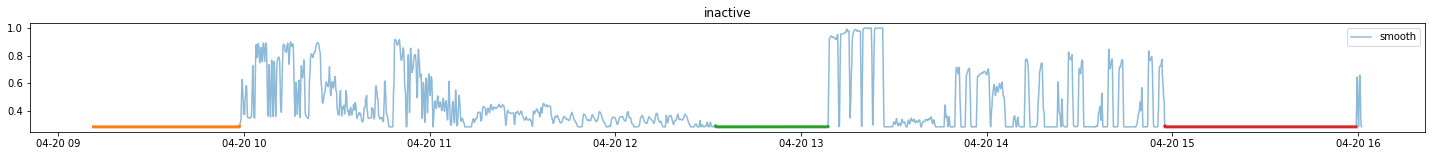

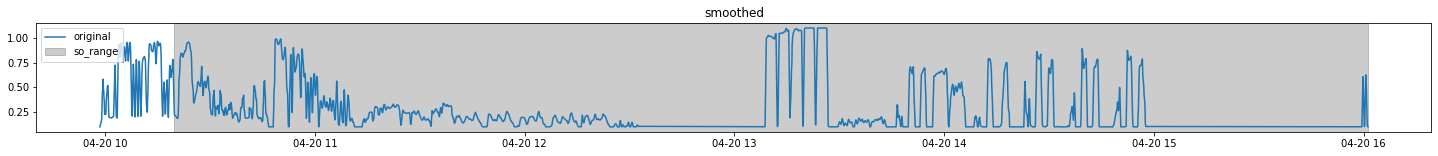

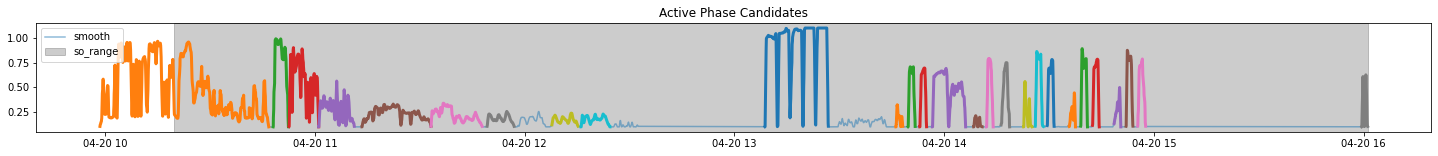

In [35]:
# index_, plotting, company = 0, True, 'yg'
plotting, company = True, 'yg'
config.plot = plotting
config.company = company

for idx_, so_ in so_df_[:1].iterrows():

    order_number_, gop_, material_, quantity_, so_time_ = so_.so, so_.gop, so_.material, int(so_.qty), so_.total_runtime
    parameter, gap, threshold, min_threshold, smooth_factor, step, upper_limit, mac_main, window, max_cycle, idle_value = params(machine)
    
    print(f'''
    {'='*100}
    index: {idx_},\t{order_number_}\t{gop_}\t{material_}\t{quantity_}      {so_.start_time} ~ {so_.stop_time}
    {'='*100}
    ''')

    # exchange padded time
    so_range = [so_.start_time, so_.stop_time]
    padded_time = so_time_*0.2 if ((so_time_ / quantity_) >= 1) or (quantity_ > 1) else so_time_*0.5

    patterns, candidates, pattern_index, start_time, _, lll, _ = pattern_history_parse(machine, order_number_)
            
    padded_range = [so_range[0] - dt.timedelta(hours=padded_time), so_range[1] + dt.timedelta(hours=padded_time)]
    plot_start_time = str(padded_range[0])
    plot_stop_time = str(stop_times[idx_+1]).replace("T", " ")[:19] if stop_times[idx_+1:idx_+2] and so_.stop_time not in stop_times[idx_+1:] else str(padded_range[1])
    period_ = fr.utils.Period([plot_start_time, plot_stop_time])

    row = WebSQL.get_data(mac=mac_main, period=period_.utc)
    data_ = fr.processor.preprocess(row)
    next_data, current_data = data_[data_.timestamp > so_range[1]], data_[data_.timestamp <= so_range[1]]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=next_data.timestamp, y=next_data.value, mode='lines', line=dict(width=2, color='#1f77b4'), opacity=0.4, name='next SO', showlegend=True))
    fig.add_trace(go.Scatter(x=current_data.timestamp, y=current_data.value, mode='lines', line=dict(width=3, color='#1f77b4'), opacity=1.0, name='current data', showlegend=True))
    fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
    fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=200, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation='h', yanchor='bottom', y=1.04, xanchor='left', x=0))
    fig.show()
    time.sleep(2)

    # temp dataRange, [padded_range[0], so_range[1]]
    temp = data_[(data_.timestamp > plot_start_time) & (data_.timestamp <= so_range[1])]
    
    # cleaning + smoothing + inactive phase detection
    times_, y_ = cleaning(temp, smooth_factor, min_threshold)
    smooth_ = smoothing(y_, step)
    times, ss, inactive_cycles_ = inactive_phase_cleaning_normalization(smooth_, times_, upper_limit, window, so_range)

    # active phase detection
    cycles_ = active_phase(ss, times, threshold, upper_limit, max_cycle * 60, gap, idle_value)
    cycles = cycle_generate(cycles_, times, ss, inactive_cycles_, so_range)
        
    active_phase_idx = 0
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pd.to_datetime(times), y=ss, mode='lines', opacity=0.3, name='smooth', showlegend=False))
    for _, c in enumerate(cycles):
        xx, yy = pd.to_datetime([aa[0] for aa in c]), [aa[1] for aa in c]
        center_idx, max_yy = int(len(xx)//2), max(yy)
        fig.add_trace(go.Scatter(x=xx, y=yy, mode='lines', name=f'{active_phase_idx}', line=dict(width=3)))
        fig.add_trace(go.Scatter(x=[xx[center_idx]], y=[max_yy*1.1], mode='markers+text', text=f'{active_phase_idx}',
                        textposition='middle center', textfont=dict(family='bold', color='black'),
                        marker=dict(color='gray',opacity=0.2,size=15, line=dict(color='black', width=2)), showlegend=False))
        active_phase_idx += 1
    fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
    fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2))
    fig.show()
    time.sleep(2)

    # cycle parameter
    cycle_parameter = parameter[machine]['cycle']
    cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 else 1000
    cycle_parameter['min_dist'] = round(max(cycle_parameter['lower_limit'] ** 0.4, 2.8), 1) * 1.3
    cycle_parameter['order'] = int(min(max(cycle_parameter['lower_limit'] ** 0.6, 5), 15))
    cycle_parameter['gap'] = 50
    cycle_parameter['n'] = 5
    cycle_parameter['cycle_gap'] = [30, 60][machine not in {"G3020 #1"}]

    ###########################
    ### detect machineCycle ###
    ###########################
    
    # quantity_ 장비마다 배수 적용
    quantity_ = quantityRedefine(machine, quantity_)

    # order_number 미사용
    patterns, candidates, first_phase, last_phase = pattern_detector(cycles, cycle_parameter, machine, order_number_)
    output, complete_cycle = best_cycle(patterns, quantity_)
    
    if output != [] and complete_cycle != []:
        store_cycle_output_and_plot(output, patterns, candidates, machine, complete_cycle, times, ss, cycles, first_phase, last_phase, material_, order_number_, store=False)
    else:
        print(f'''
              {'='*100}
                **ERROR**\tindex: {idx_},\t{order_number_}\t{gop_}\t{material_}\t{quantity_}      {so_.start_time} ~ {so_.stop_time}
              {'='*100}
               ''')